In [56]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# RIN Curation

Read in table of RNA Integrity Numbers (RINs). This table was made by concatenating all of the analyte tables taken from **biospecimen data** from the [GDC legacy site](https://gdc-portal.nci.nih.gov/legacy-archive). The data is not available on the [new GDC site](https://gdc-portal.nci.nih.gov), nor from their API, despite being listed as a [valid endpoint](https://gdc-docs.nci.nih.gov/API/Users_Guide/Search_and_Retrieval/#cases-endpoint).

Commands to create combined table
```bash
head -1 nationwidechildrens.org_biospecimen_analyte_acc.txt > header
for i in *; do sed '1,2d' $i > $i.fixed; done
cat header *fixed > biospecimen_analyte_combined.tsv
```

The biospecimen_analyte_combined.tsv can be downloaded from [Synapse](Synapse.org) under the id: `syn7499603`.

In [172]:
df = pd.read_csv('biospecimen_analyted_combined.tsv', sep='\t')
df.head(2)

,bcr_patient_uuid,bcr_sample_barcode,bcr_analyte_barcode,bcr_analyte_uuid,a260_a280_ratio,analyte_type,analyte_type_id,concentration,gel_image_file,is_derived_from_ffpe,normal_tumor_genotype_match,pcr_amplification_successful,ratio_28s_18s,rinvalue,spectrophotometer_method,subportion_sequence,well_number
0,B3164F7B-C826-4E08-9EE6-8FF96D29B913,TCGA-OR-A5J1-01A,TCGA-OR-A5J1-01A-11D,56146956-9343-4C85-A9D1-AC708CA78E7E,[Not Available],DNA,D,0.15,https://sharedoc.nchri.org/tcga-bcr/default.aspx,NO,YES,YES,[Not Available],[Not Available],PicoGreen,1,[Not Available]
1,B3164F7B-C826-4E08-9EE6-8FF96D29B913,TCGA-OR-A5J1-01A,TCGA-OR-A5J1-01A-11R,B3BD12BD-0655-4E1F-8EDB-E1E88E1A29A9,1.87,RNA,R,0.18,https://sharedoc.nchri.org/tcga-bcr/default.aspx,NO,[Not Available],[Not Available],1.37,8.50,UV Spec,1,[Not Available]


Subset dataframe

In [106]:
rin = df[df.analyte_type == 'RNA']

Cast RIN values as numbers, non-values as NaNs. Pandas reads this column type in as strings (dtype O) by default since not every value in the column is numeric.

In [113]:
rin.rinvalue.dtypes

dtype('O')

In [114]:
rin.rinvalue = pd.to_numeric(rin.rinvalue, errors='coerce')

Cast UUIDs as lowercase to match TCGA table

In [115]:
rin.bcr_patient_uuid = rin.bcr_patient_uuid.apply(lambda x: x.lower())

In [116]:
rin.head(2)

,bcr_patient_uuid,bcr_sample_barcode,bcr_analyte_barcode,bcr_analyte_uuid,a260_a280_ratio,analyte_type,analyte_type_id,concentration,gel_image_file,is_derived_from_ffpe,normal_tumor_genotype_match,pcr_amplification_successful,ratio_28s_18s,rinvalue,spectrophotometer_method,subportion_sequence,well_number
1,b3164f7b-c826-4e08-9ee6-8ff96d29b913,TCGA-OR-A5J1-01A,TCGA-OR-A5J1-01A-11R,B3BD12BD-0655-4E1F-8EDB-E1E88E1A29A9,1.87,RNA,R,0.18,https://sharedoc.nchri.org/tcga-bcr/default.aspx,NO,[Not Available],[Not Available],1.37,8.5,UV Spec,1,[Not Available]
6,8e7c2e31-d085-4b75-a970-162526dd07a0,TCGA-OR-A5J2-01A,TCGA-OR-A5J2-01A-11R,9288D083-5303-4456-9208-C81FD8E5F374,1.83,RNA,R,0.17,https://sharedoc.nchri.org/tcga-bcr/default.aspx,NO,[Not Available],[Not Available],1.61,9.0,UV Spec,1,[Not Available]


We need to reset the pandas index, otherwise when we create a new dataframe using the `rinvalue` and `bcr_patient_uuid`, the index carried along in the `Series` information will create problems.

In [221]:
rin.reset_index(inplace=True)

Let's plot the distribution of RIN values, excluding NaNs. GTEx recommends only using data that has an RIN of 6 or above.

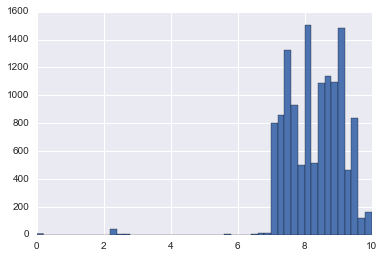

In [245]:
plt.hist(rin[pd.notnull(rin.rinvalue)].rinvalue, bins=50);
plt.savefig('RIN_distribution.pdf', format='pdf')

In [123]:
print 'Number of RIN < 6: ' + str(len(rin[rin.rinvalue < 6].rinvalue))

Number of RIN < 6: 76


How much of the data does not have an RIN?

In [223]:
print 'Number of samples: ' + str(len(rin))
print 'Number of NaNs: ' + str(rin.rinvalue.isnull().sum())
print 'Percentage: {}%'.format(round(rin.rinvalue.isnull().sum()*1.0 / len(rin), 2))

Number of samples: 13402
Number of NaNs: 470
Percentage: 0.04%


## Creating a Table of RIN / Diseases / Analysis IDs
The GDC table associates an RIN value with a *bcr_patient_uuid*. This UUID can be associated with an *analysis_id* that all of the recompute data is tagged through a TCGA metadata table. We'll boil this down to a 3-column table: analysis_id, disease_name, and rinvalue

In [81]:
tcga = pd.read_csv('unaligned.tsv', sep='\t')

In [100]:
tcga.head(1)

,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,library_type,center,center_name,...,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,state,reason
0,TCGA,TCGA-DQ-5630-01A-01R-1873-07,HNSC,Head and Neck squamous cell carcinoma,TP,1,RNA,RNA-Seq,UNC-LCCC,UNC-LCCC,...,13c839d1-f77b-4bde-9bd5-8d5165d94346,91a712b5-a724-48d0-ba06-4f6857683463,a0cdb208-e66f-4ad7-86fa-5077145a4a68,DQ,,2013-09-27,2013-09-25,2013-09-27,Live,


Create dataframe and columns. The `.max()` function is a clunky way to pull a single value out of a Series with one value, without the additional pandas info.

In [225]:
patient_ids = rin.bcr_patient_uuid
rinvalues = rin.rinvalue
analysis_ids = [tcga[tcga.participant_id == x].analysis_id.max() for x in patient_ids]
diseases = [tcga[tcga.analysis_id == x].disease_name.max() for x in analysis_ids]

In [227]:
out = pd.DataFrame()
out['analysis_id'] = analysis_ids
out['rin'] = rinvalues
out['disease'] = diseases

In [228]:
out.head(2)

,analysis_id,rin,disease
0,cdae7e4e-1338-4267-a0f2-98074510a090,8.5,Adrenocortical carcinoma
1,f3b57849-0302-47b0-9e3b-7cbe9de07056,9.0,Adrenocortical carcinoma


Drop rows where there are null values in the analysis_id column.

In [233]:
out = out[pd.notnull(out.analysis_id)]

### Questions about the data
Which samples have RIN values less than 6?

In [241]:
print 'Number of samples with RIN < 6.0: ' + str(len(out[out.rin < 6]))
out[out.rin < 6].disease.value_counts()

Number of samples with RIN < 6.0: 60


Colon adenocarcinoma                                                13
Breast invasive carcinoma                                           13
Lung adenocarcinoma                                                 12
Kidney renal clear cell carcinoma                                    6
Uterine Corpus Endometrioid Carcinoma                                4
Prostate adenocarcinoma                                              4
Bladder Urothelial Carcinoma                                         3
Rectum adenocarcinoma                                                1
Cervical squamous cell carcinoma and endocervical adenocarcinoma     1
Lung squamous cell carcinoma                                         1
Glioblastoma multiforme                                              1
Liver hepatocellular carcinoma                                       1
Name: disease, dtype: int64

Which samples have NaN values?

In [238]:
out[pd.isnull(out.rin)].disease.value_counts()

Glioblastoma multiforme    52
Rectum adenocarcinoma       1
Name: disease, dtype: int64

In [242]:
out = out.sort_values('rin')

Save the output table

In [244]:
out.to_csv('tcga_rin_values.tsv', sep='\t')

This tcga_rin_values.tsv can be downloaded from [Synapse](Synpase.org) under the id: `syn7499606`